# Network Science - MDS - UDD 2022
## Introducción a Ciencia de Redes


#### Cristian Candia-Castro Vallejos, Ph.D.$^{1,2}$

- [1] Data Science Institute (IDS), Universidad del Desarrollo,Chile
- [2] Northwestern Institute on Complex Systems, Kellogg School of Management, Northwestern Unviersity, USA


Referencias:
1. http://networksciencebook.com/translations/en/resources/data.html
2. http://www-personal.umich.edu/~mejn/netdata/

# TAREA 3

Tienen 2 semana para entregar esta tarea en ipython notebook en grupos de no más de 4 personas. 

# Ejercicio 1 - Detección de comunidades en una red grande.
***Instricciones:***
1. Usa la funcioón `read_gml` para cargar la red en`group1.gml`.
2. Calcule la partición óptima de la red de acuerdo con el algoritmo fast greedy.
3. ¿Cuáles son los tamaños de las dos comunidades más grandes en relación con el tamaño de la red? ¿Cuántos nodos quedan en otras comunidades?
4. Siguiendo los ejemplos de la red de karate, dibuje la red con las dos mayores comunidades en dos colores diferentes como se muestra arriba. Puedes colorear los nodos restantes en gris. Comenta sobre lo que ves. Le sugiero que desactive las etiquetas de nodo y reduzca el tamaño del nodo a `node_size=20` para mayor claridad, ya que la red es grande. Use `pos=nx.kamada_kawai_layout(G)`
5. Mire el archivo GML sin procesar y vea si puede adivinar qué es la red.
6. ¿Qué sospecha que representan los nodos "sobrantes"? (de nuevo, el archivo GML probablemente te pueda dar una pista si los buscas)

Importamos las librerias a utilizar.

In [425]:
import networkx as nx
import numpy as np
import scipy.cluster.hierarchy as hierarchy
%matplotlib inline
import itertools as it
import heapq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import community


### 1) Usa la funcioón read_gml para cargar la red engroup1.gml.

In [426]:
Gt = nx.read_gml("./group1.gml")# Lee archivo

In [427]:
print(nx.info(Gt))

Graph with 1222 nodes and 16717 edges


C:\Users\leand\AppData\Local\Temp\ipykernel_36412\370307085.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(Gt))


### 2) Calcule la partición óptima de la red de acuerdo con el algoritmo fast greedy.

In [428]:
def get_community_matrix(A, com):
    n = len(A)
    
    # número de comunidades
    nc = len(set(com))

    # Inicializar lista de matrices de adyacencia
    e = np.zeros((nc, nc))

    # Crea enlace y normaliza valores dividiendo por la suma de todos los enlaces (dependiente del tamaño de la red)
    m = 0
    for i in range(n):
        for j in range(n):
            if A[i, j] != 0:
                ic = com[i]
                jc = com[j]
                if ic == jc:
                    e[ic,ic] += A[i, j]
                else:
                    e[ic,jc] += 0.5*A[i,j]
                    e[jc,ic] = e[ic,jc]
                m += A[i,j]
    return e/m

In [429]:
def fast_greedy(Gt):
    import heapq

    L = Gt.size()
    #L = len(G.edges())
    for u, v in Gt.edges():
        #G.edge[u][v]['weight'] = 1.0/(2.0*L)
        Gt[u][v]['weight']=1.0/(2.0*L)
    for u in Gt:
        Gt.nodes[u]['weight'] = Gt.degree(u)/(2.0*L)
    
    # crear un nuevo grafo donde los nodos son comunidades (conjuntos de nodos)
    # se debe usar frozenset() ya que los nodos necesitan ser hashable
    H = nx.relabel_nodes(Gt, {node:frozenset((node,)) for node in Gt}, copy=True)
    heap = []
    heapq.heapify(heap)

    # peso del enlace i,j en H 
    def e(i, j):
        if H.has_edge(i, j):
            #return H.edge[i][j]['weight']
            return H[i][j]['weight']

        else:
            return 0
    
    # peso del nodo i en H 
    def a(i):
        if i in H:
            return H.nodes[i]['weight']
        else:
            return 0
        
    def get_best_pair():
        # retorna el par de nodos que maximiza el incrmento de Q en H
        while True:
            try:
                dQ, c1, c2 = heapq.heappop(heap)
            except IndexError:
                # Si no hay par, significa (habitualmente) que es grafor es disconexo
                return None, None, None
            if c1 in H and c2 in H:
                # el mejor par debe involucrar elementos que no han sido fusionados
                break
        # python's heap is a min-heap
        return -dQ, c1, c2
    
    def Q_change(c1, c2):
        return 2*(e(c1, c2) - a(c1)*a(c2)) 
    
    def add_to_heap(c1, c2):
        dQ = Q_change(c1, c2)
        # python's heap is a min-heap
        heapq.heappush(heap, (-dQ, c1, c2))
        
    def merge(c1, c2):
        comb = c1 | c2
        H.add_node(comb, weight=a(c1)+a(c2))
        #para los vecinos en el conjunto H.neighbors(c1) + H.neighbors(c2):
        for nbr in list(H.neighbors(c1)) + list(H.neighbors(c2)):
            
            # ignorar los enlaces internos en el "fusionador"
            if nbr == c1 or nbr == c2:
                continue
            # el peso total es la suma de los pesos antiguos
            H.add_edge(comb, nbr, weight=e(c1, nbr)+e(c2, nbr))
            add_to_heap(comb, nbr)
        H.remove_nodes_from([c1, c2])
        
    #for c1, c2 in H.edges_iter():
    for c1, c2 in list(dict(H.edges())):  
        add_to_heap(c1, c2)    
        
    L = H.size()
    #k = np.array(G.degree().values())
    k = np.array(list(dict(Gt.degree()).values()))
    Q = -sum(k**2)/(4.0*L**2)
    best_Q = Q
    best_partition = None
    
    while len(H) > 1:
        dQ, c1, c2 = get_best_pair()
        if c1 is None or c2 is None:
            break
        merge(c1, c2)
        Q += dQ 
        
        if Q > best_Q:
            best_Q = Q
            #best_partition = H.nodes()
            best_partition = list(dict(H.nodes()))

    return list(map(tuple, best_partition)), best_Q

In [430]:
Gt = nx.read_gml("./group1.gml")
best_partition, Q = fast_greedy(Gt)
print("La mejor partición encontrada consiste en {0} comunidad{1}:".format(
        len(best_partition), "" if len(best_partition) == 1 else "es"))
for c in best_partition:
    print(c)
print("La modularidad de esta particion es:", Q)

La mejor partición encontrada consiste en 10 comunidades:
('enemykombatant.blogspot.com', 'democratvoice.org')
('massachusetts-liberal.com', 'openeyesmemo.com')
('nicoladellarciprete.blogs.com', 'imprescindibile.ilcannocchiale.it')
('tinylittledots.com', 'theantibush.org', 'lennonreport.blogspot.com')
('aldaron.modblog.com', 'quimundus.modblog.com', 'quimundus.squarespace.com')
('eltcamerica.blogspot.com', 'smashingzero.blogspot.com', 'churchofcriticalthinking.com', 'blog.veggiedude.com')
('americanworldview.tripod.com/weltansblog', 'batr.org/commentary.html', 'shininglight.us', 'batr.net', 'neoconswatch.blogspot.com')
('charlesking.blogspot.com', 'charleypatton.blogspot.com', 'nathancallahan.com', 'nycitystoop.com', 'conservativepolitics.blogspot.com', 'chiefsblog.blogspot.com', 'ergio.blogspot.com', 'forewarned.blogspot.com', 'maggiespants.co.uk', 'alphapredator.com/wdtgw.htm', 'cptnwinky.com', 'limericksavant.blogspot.com', 'etalkinghead.com', 'myechochamber.blogspot.com', 'blog.den

La partición optima de la red de acuerdo con el algoritmo fast greedy es de 10 comunidades, con una modularidad de partición de 0.42675.

### 3) ¿Cuáles son los tamaños de las dos comunidades más grandes en relación con el tamaño de la red? ¿Cuántos nodos quedan en otras comunidades?

In [431]:
print(nx.info(Gt))

Graph with 1222 nodes and 16717 edges


C:\Users\leand\AppData\Local\Temp\ipykernel_36412\370307085.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(Gt))


In [432]:
i = 0
comunity = {}
comunity_len = {}
for c in best_partition:
    comunity[i] = c
    i= i+1

for i in range(len(comunity)):
    comunity_len[i] = len(comunity[i])

    
df_comunity_len = pd.DataFrame.from_dict(comunity_len, orient='index', columns=['Size']).sort_values('Size',ascending=False)
       
print(df_comunity_len.iloc[0:2])
print(int(df_comunity_len.iloc[0:1].sum()/df_comunity_len.iloc[0:10].sum()*100),'%')
print(int(df_comunity_len.iloc[1:2].sum()/df_comunity_len.iloc[0:10].sum()*100),'%')
print(df_comunity_len.iloc[2:10].sum())

   Size
8   634
9   544
51 %
44 %
Size    44
dtype: int64


El tamaño de la red consta de 1222 nodos distribuida en 10 comunidades. Las 2 comunidades con mayor tamaño (c9 y c10) cuentan con 634 nodos y un 51% en relación con el tamaño de la red y 544 nodos con un 44% en relación al tamaño de la red. El resto de nodos en las otras comunidades corresponden a 44. 

### 3) Siguiendo los ejemplos de la red de karate, dibuje la red con las dos mayores comunidades en dos colores diferentes como se muestra arriba. Puedes colorear los nodos restantes en gris. Comenta sobre lo que ves. Le sugiero que desactive las etiquetas de nodo y reduzca el tamaño del nodo a node_size=20 para mayor claridad, ya que la red es grande. Use pos=nx.kamada_kawai_layout(G)

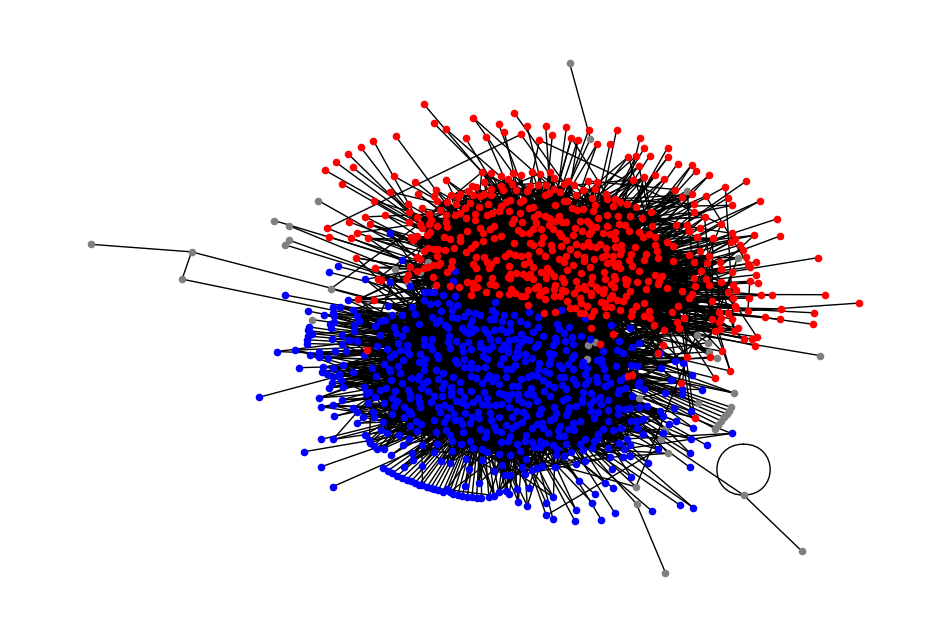

In [433]:
c1, c2 ,c3, c4, c5, c6, c7, c8, c9, c10 = best_partition

colors = ['gray', 'gray','gray','gray', 'gray','gray','gray', 'gray','blue','red']
pos=nx.kamada_kawai_layout(Gt)
plt.figure(figsize=(12,8))
nx.draw_networkx_edges(Gt, pos)

for community, color in zip(best_partition, colors):
    nx.draw_networkx_nodes(Gt, pos=pos, nodelist=community, node_color=color, node_size=20)
#nx.draw_networkx_labels(Gt, pos=pos)
_ = plt.axis('off')

### 5) Mire el archivo GML sin procesar y vea si puede adivinar qué es la red.

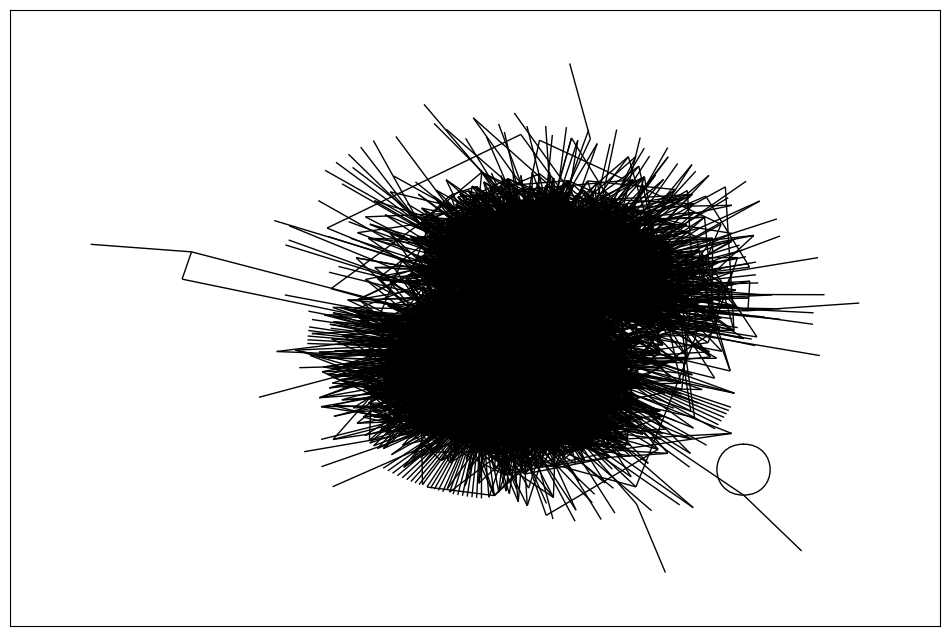

In [434]:
plt.figure(figsize=(12,8))
nx.draw_networkx_edges(Gt, pos=pos)

In [435]:
nodelist = list(Gt.nodes(data=True)) 
node_df = pd.DataFrame(nodelist, columns=['Nodo', 'Atributos']) 
node_df

,Nodo,Atributos
0,100monkeystyping.com,"{'value': 0, 'source': 'Blogarama', 'weight': ..."
1,12thharmonic.com/wordpress,"{'value': 0, 'source': 'BlogCatalog', 'weight'..."
2,750volts.blogspot.com,"{'value': 0, 'source': 'Blogarama', 'weight': ..."
3,95theses.blogspot.com,"{'value': 0, 'source': 'Blogarama', 'weight': ..."
4,abbadabbaduo.blogspot.com,"{'value': 0, 'source': 'Blogarama,LeftyDirecto..."
...,...,...
1217,youngconservative.blogspot.com,"{'value': 1, 'source': 'Blogarama', 'weight': ..."
1218,zebrax.blogs.com,"{'value': 1, 'source': 'BlogCatalog', 'weight'..."
1219,zeke01.blogspot.com,"{'value': 1, 'source': 'Blogarama,BlogCatalog'..."
1220,zeke01.typepad.com,"{'value': 1, 'source': 'Blogarama', 'weight': ..."


Podemos ver que los datos corresponden a diferentes blogs de carácter político. Por lo que la red debe representar la interacción hacia esos blogs de acuerdo con el contenido político de ellos.

### 6) ¿Qué sospecha que representan los nodos "sobrantes"? (de nuevo, el archivo GML probablemente te pueda dar una pista si los buscas)

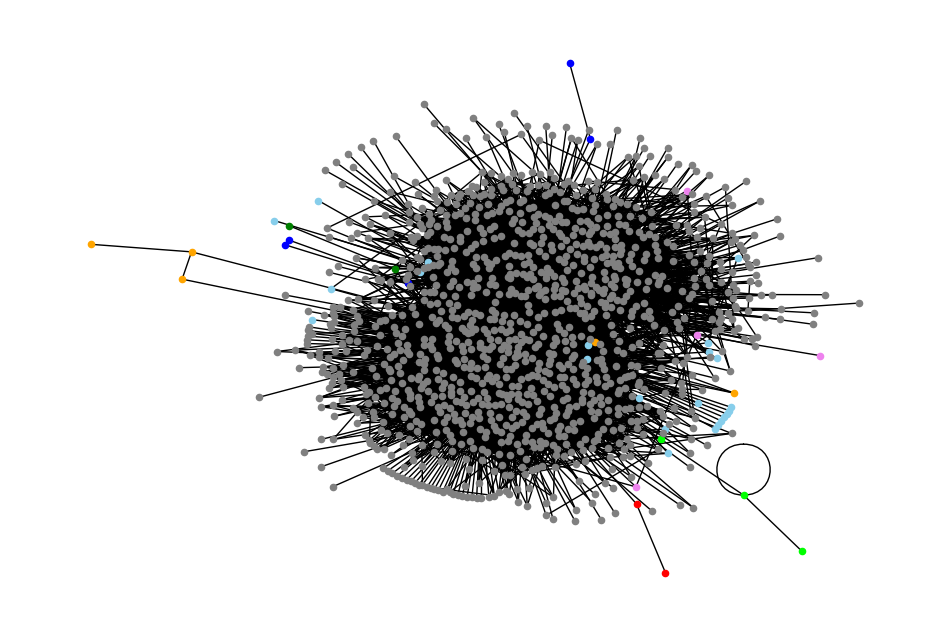

In [436]:
pos = nx.kamada_kawai_layout(Gt)

c1, c2 ,c3, c4, c5, c6, c7, c8, c9, c10 = best_partition

colors = ['red', 'blue','green','blue', 'lime','violet','orange', 'skyblue', 'gray', 'gray']

plt.figure(figsize=(12,8))
nx.draw_networkx_edges(Gt, pos)

for community, color in zip(best_partition, colors):
    nx.draw_networkx_nodes(Gt, pos=pos, nodelist=community, node_color=color, node_size=20)
#nx.draw_networkx_labels(Gt, pos=pos)
_ = plt.axis('off')

Los nodos sobrantes representan comunidades con un o dos enlaces y que tienen una centralidad de grado baja.